## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## First, I'll perform a Histogram of Oriented Gradients (HOG) feature extraction on a test image. I will also extract spatial and color features from the label data.

/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


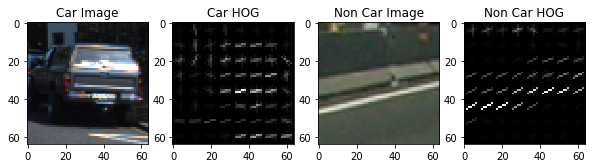

In [73]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from glob import glob
from skimage.feature import hog
%matplotlib inline


# get HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                   cells_per_block=(cell_per_block, cell_per_block),
                                   visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)         
        return features    

# get bins of spatial features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 

# get histogram of color features
def color_hist(img, nbins=32, bins_range=(0, 256)): 
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    

cars = []
start_dir = 'vehicles'
pattern   = "*.png"

for dir,_,_ in os.walk(start_dir):
    cars.extend(glob(os.path.join(dir,pattern)))

not_cars = []    
start_dir = 'non-vehicles'

for dir,_,_ in os.walk(start_dir):
    not_cars.extend(glob(os.path.join(dir,pattern)))

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
car_image = mpimg.imread(cars[ind])
# Read in the image
non_car_image = mpimg.imread(not_cars[ind])

# convert to gray scale
gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)    
# convert to gray scale
gray_non_car = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2GRAY)

# define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
features, non_car_hog_image = get_hog_features(gray_non_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)  
# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image')
plt.subplot(142)    
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car HOG')
plt.subplot(143)
plt.imshow(non_car_image, cmap='gray')
plt.title('Non Car Image')
plt.subplot(144)    
plt.imshow(non_car_hog_image, cmap='gray')
plt.title('Non Car HOG')

plt.savefig('HOG_Features.jpg')


---
## Next, I'll run the feature extractions on each label image and label the data accordingly. I will then train the classifier to associate the car/non-car features with the corresponding label. 

In [89]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        spat_hist_feat = np.concatenate((spatial_features, hist_features))       
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         features.append(np.concatenate((hog_features,spat_hist_feat)))
        features.append(hog_features)

        # Return list of feature vectors
    return features            

# Reduce the sample size because HOG features are slow to compute
sample_size = 2000
cars = cars[0:sample_size]
not_cars = not_cars[0:sample_size]

# set parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins=32
hist_range=(0, 256)

# get features from cars ot not cars
car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(not_cars, cspace=colorspace, spatial_size=spatial_size,
                                   hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9962
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]


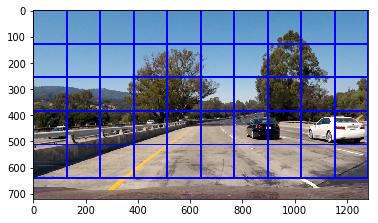

In [45]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# image = mpimg.imread('test_images/test1.jpg')

# # Here is your draw_boxes function from the previous exercise
# def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
#     # Make a copy of the image
#     imcopy = np.copy(img)
#     # Iterate through the bounding boxes
#     for bbox in bboxes:
#         # Draw a rectangle given bbox coordinates
#         cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
#     # Return the image copy with boxes drawn
#     return imcopy
    
# # Define a function that takes an image,
# # start and stop positions in both x and y, 
# # window size (x and y dimensions),  
# # and overlap fraction (for both x and y)
# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#     # If x and/or y start/stop positions not defined, set to image size
#     if x_start_stop[0] == None: # default is 0  for start
#         x_start_stop[0] = 0
#     if y_start_stop[0] == None: # default is 0
#         y_start_stop[0] = 0
#     if x_start_stop[1] == None: # default is end for stop
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]

#     # Compute the span of the region to be searched (start/stop region)   
#     x_span = x_start_stop[1] - x_start_stop[0]
#     y_span = y_start_stop[1] - y_start_stop[0]

#     # Compute the number of pixels per step in x/y
#     nx_step =  np.int(xy_window[0]*(1-xy_overlap[0]))
#     ny_step =  np.int(xy_window[1]*(1-xy_overlap[1]))
#     # Compute the number of windows in x/y
#     # compute single window value window*overlapfraction
#     nx_margin =  np.int(xy_window[0]*xy_overlap[0])
#     ny_margin =  np.int(xy_window[1]*xy_overlap[1])
#     nx_windows =  np.int((x_span-nx_margin)/nx_step)
#     ny_windows =  np.int((y_span-ny_margin)/ny_step)
#     # Initialize a list to append window positions to
#     window_list = []
#     # Loop through finding x and y window positions
#     #     Note: you could vectorize this step, but in practice
#     #     you'll be considering windows one by one with your
#     #     classifier, so looping makes sense
#         # Calculate each window position
#         # Append window position to list
#     xy_start = (x_start_stop[0],y_start_stop[0]) 
#     xy_stop =  (x_start_stop[1],y_start_stop[1]) 
    
#     for x_win in range(nx_windows): 
#         for y_win in range(ny_windows):
#             # starting point + window
#             x_start = xy_start[0]+x_win*nx_step # x0,y0 -> x0+n*stepsize
#             y_start = xy_start[1]+y_win*ny_step
#             x_end = x_start + xy_window[0] # x0+n*stepsize + xwindow_size
#             y_end = y_start + xy_window[1]            
#             window_list.append(((x_start,y_start),(x_end,y_end)))
            
#     # Return the list of windows
#     return window_list

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(256, 256), xy_overlap=(0.5, 0.5))
                       
# window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
# plt.imshow(window_img)

In [90]:
img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, cspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            #test_prediction = svc.predict(test_features)
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            #print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
ystart = 400
ystop = 656
scale = 1.5
    
# set parameters
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins=32
hist_range=(0, 256)    
    
rectangles = find_cars(img, ystart, ystop, cspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


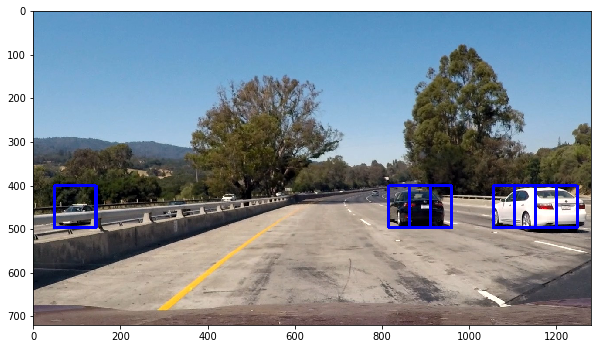

In [91]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img_rects = draw_boxes(img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)